# IEEE Fraud Detection

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## 1 - Carregando os datasets

In [2]:
df_train_id = pd.read_csv("data/train_identity.csv")
df_train_tr = pd.read_csv("data/train_transaction.csv")
df_test_id = pd.read_csv("data/test_identity.csv")
df_test_tr = pd.read_csv("data/train_transaction.csv")

In [3]:
df_train_id.shape, df_train_tr.shape, df_test_id.shape, df_test_tr.shape

((144233, 41), (590540, 394), (141907, 41), (590540, 394))

In [32]:
df_train = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')
df_test = pd.merge(df_test_tr, df_test_id, on='TransactionID', how='left')

In [33]:
# Retirando a coluna isFraud para podermos fazer a predição desta
df_test.drop(columns=['isFraud'], axis=1, inplace=True)

In [34]:
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(590540, 433)


In [35]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [36]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Variável alvo
target = df_train['isFraud'].value_counts()
target

0    569877
1     20663
Name: isFraud, dtype: int64

In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


## 2 - Análise Exploratória

### Transaction Amount

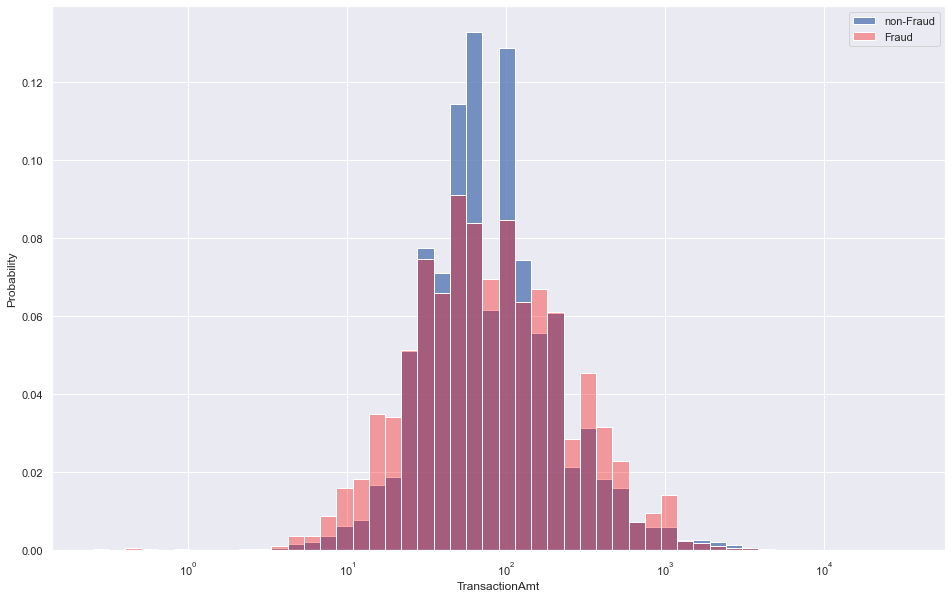

In [102]:
bins = np.histogram_bin_edges(np.log10(df_train['TransactionAmt']), bins=50)

plt.figure(figsize=(16,10))

# plt.subplot(121)
px = sns.histplot(data=df_train, x='TransactionAmt', label='non-Fraud',
                  bins=bins, stat='probability', log_scale=True)


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True], x='TransactionAmt', bins=bins,
                   stat='probability', log_scale=True, color='red', alpha=0.35, label='Fraud')


plt.legend()
plt.show()

### TransactionDT

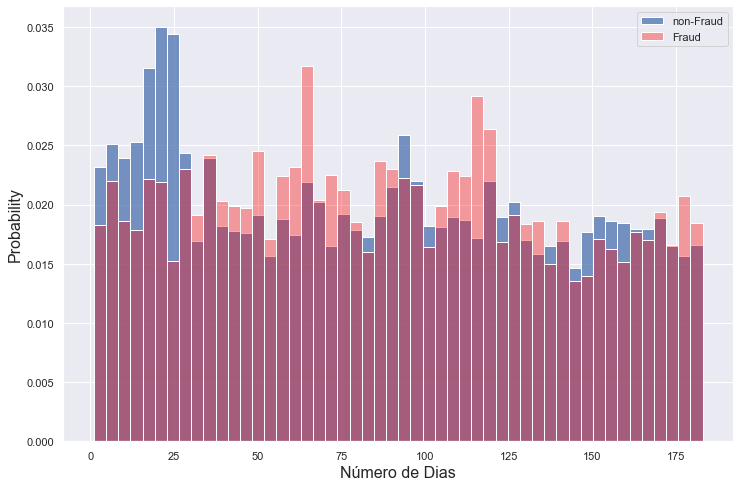

In [124]:
bins = np.histogram_bin_edges(df_train['TransactionDT'] / 86400, bins=50)

fig = plt.figure(figsize=(12,8))

# plt.subplot(121)
px = sns.histplot(data=df_train['TransactionDT'] / 86400, label='non-Fraud',
                  bins=bins, stat='probability')


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True]['TransactionDT'] / 86400, bins=bins,
                   stat='probability', color='red', alpha=0.35, label='Fraud')

px2.set_xlabel('Número de Dias', fontsize=16)
px2.set_ylabel('Probability', fontsize=16)
plt.legend()
plt.show()

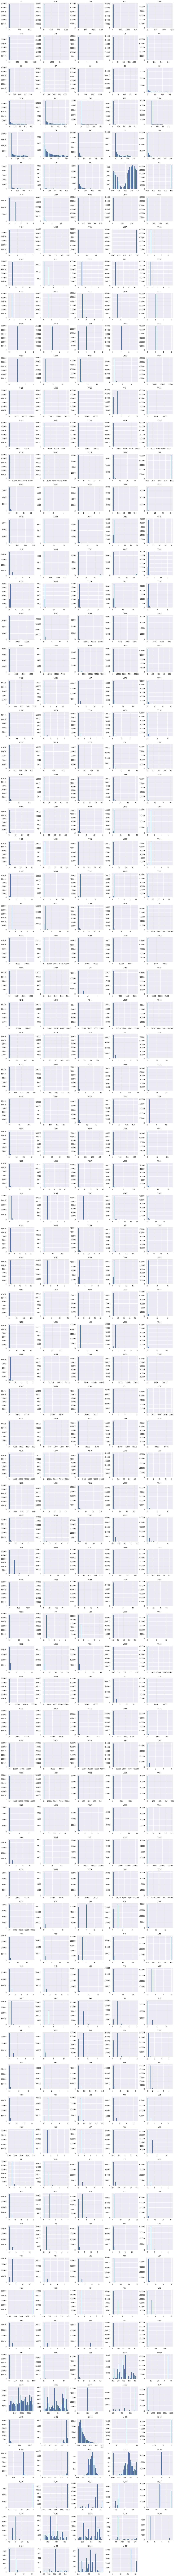

In [142]:
df_train[df_train.columns.difference(['TransactionID', 'TransactionDT', 'isFraud', 'TransactionAmt'])].hist(figsize=(20,348), layout=(87, 5), bins=30);


#### Avaliando o tipo de aparelho em que a transação foi realizada

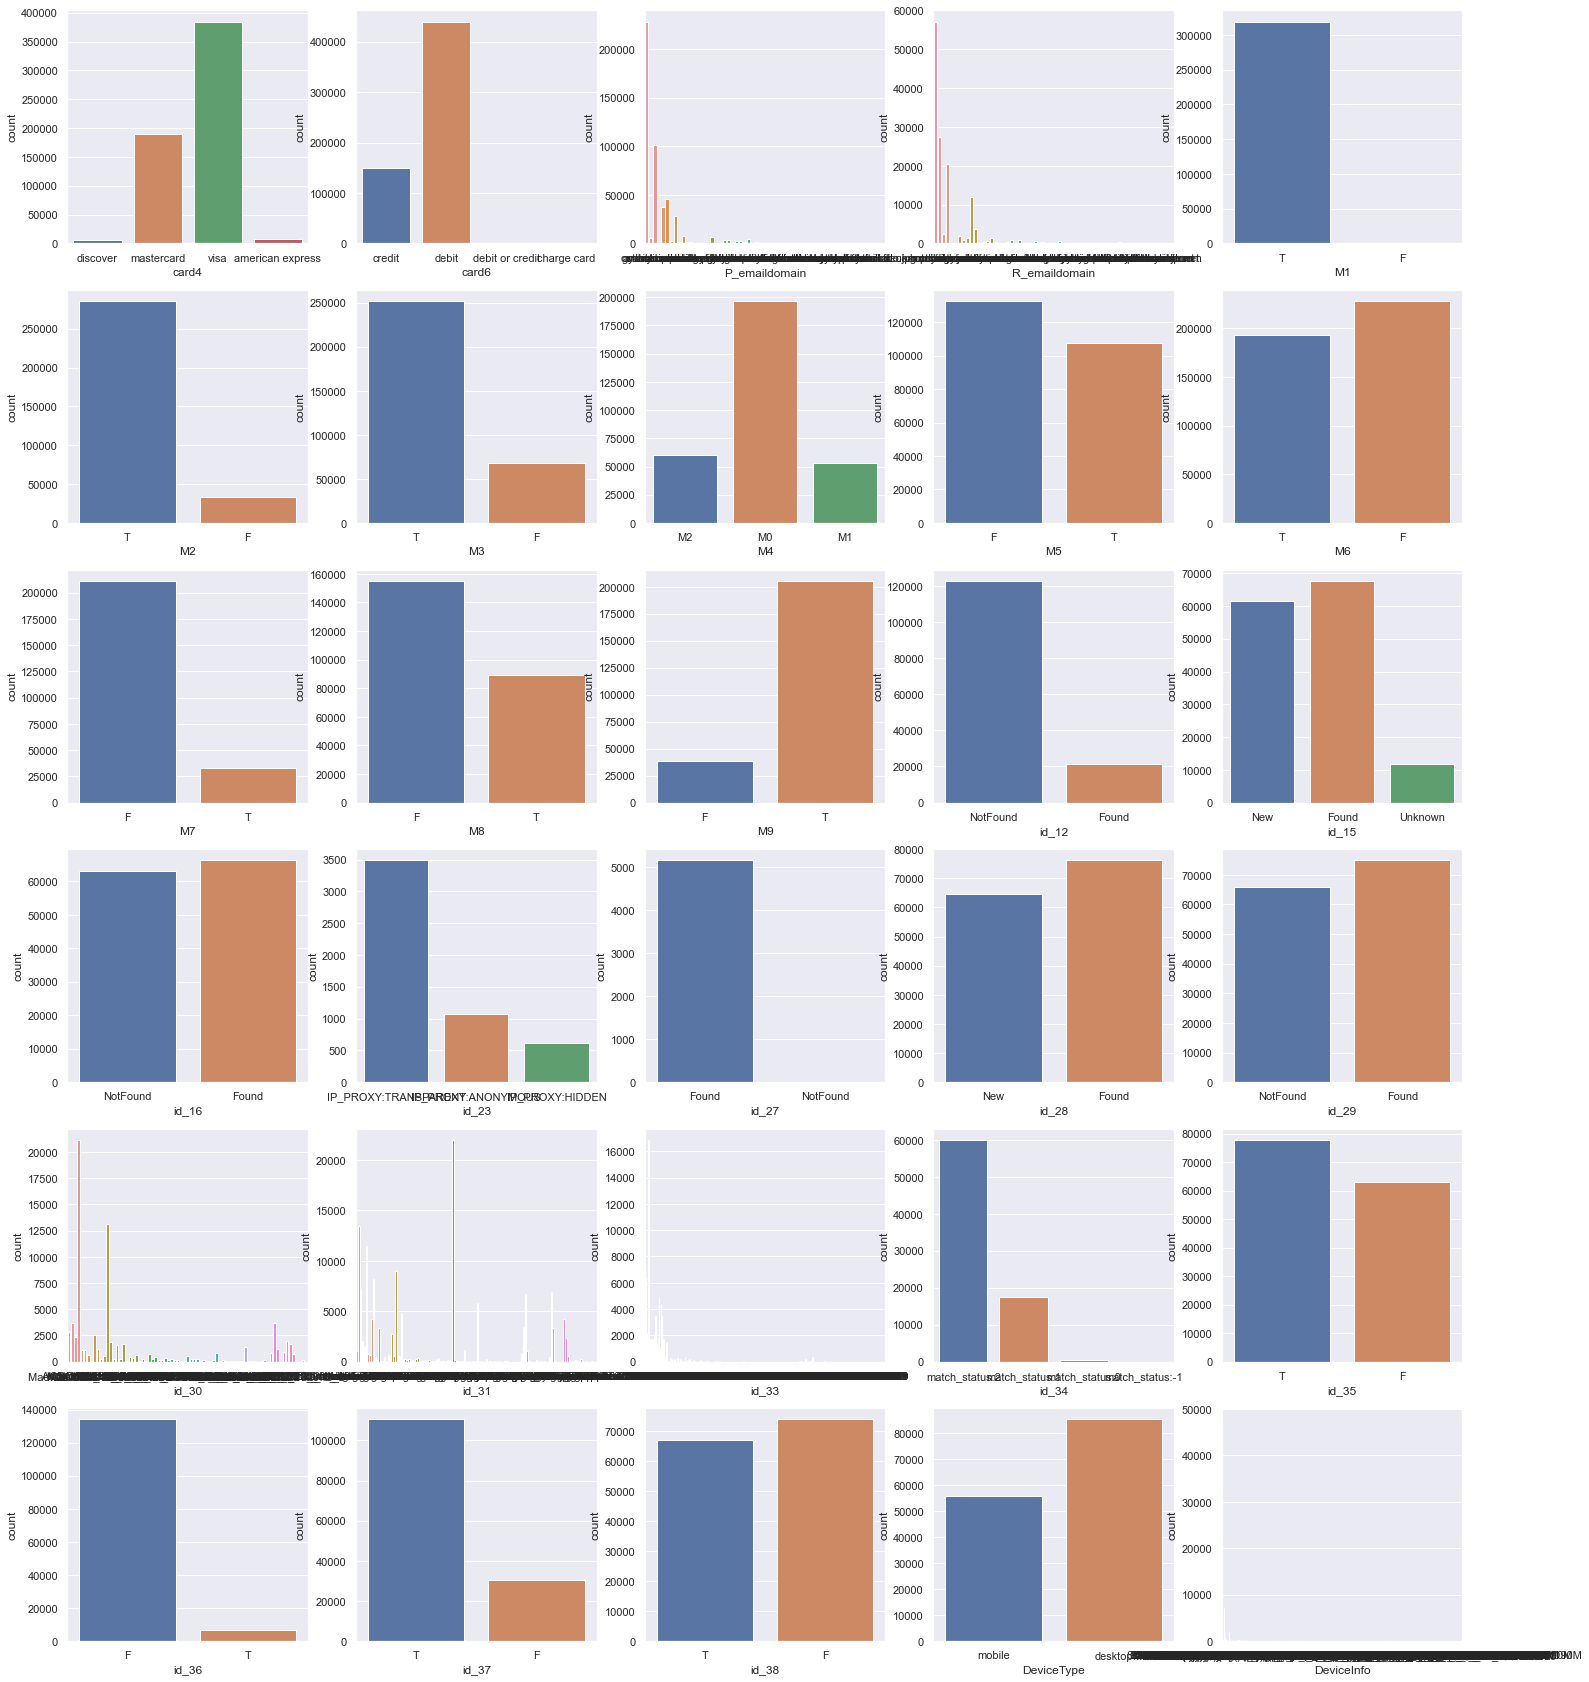

In [159]:
devicetype_freq = pd.DataFrame.from_dict(df_train['DeviceType'].value_counts(normalize=True, dropna=False))

devicetype_freq.rename(columns={'DeviceType': 'Freq'}, inplace=True)
devicetype_freq

categorical_columns = df_train.select_dtypes(exclude=np.number).columns.to_list()

fig, axes = plt.subplots(6, 5, figsize=(25, 30))

aux = 1

for row in axes:
    for column in row:

        sns.countplot(data=df_train, x=categorical_columns[aux], ax=column)
        aux += 1


plt.show()